## Part 1 ‐ Exploratory data analysis

In [67]:
#Importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from datetime import datetime

In [68]:
#loading JSON into dataframe, creating a column in which to count by.
#Converting 'login_time' to datetime, setting as index, dropping original 'login_time' column
login_data = pd.read_json("logins.json")
login_data['login_count'] = 1
login_data = login_data.set_index(pd.to_datetime(login_data['login_time'], unit='s'))[['login_count']]
login_data


,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


In [69]:
#Aggregating data on 15 minute intervals
delta = login_data.resample('15Min').sum()

In [70]:
#Sorting results to display top 10
delta.sort_values('login_count', ascending = False).head(10)

,login_count
login_time,
1970-03-01 04:30:00,73
1970-04-04 05:30:00,66
1970-04-04 01:30:00,64
1970-04-04 01:15:00,63
1970-04-01 23:30:00,60
1970-04-04 05:00:00,60
1970-04-04 04:45:00,59
1970-04-04 05:15:00,59
1970-04-04 01:45:00,56


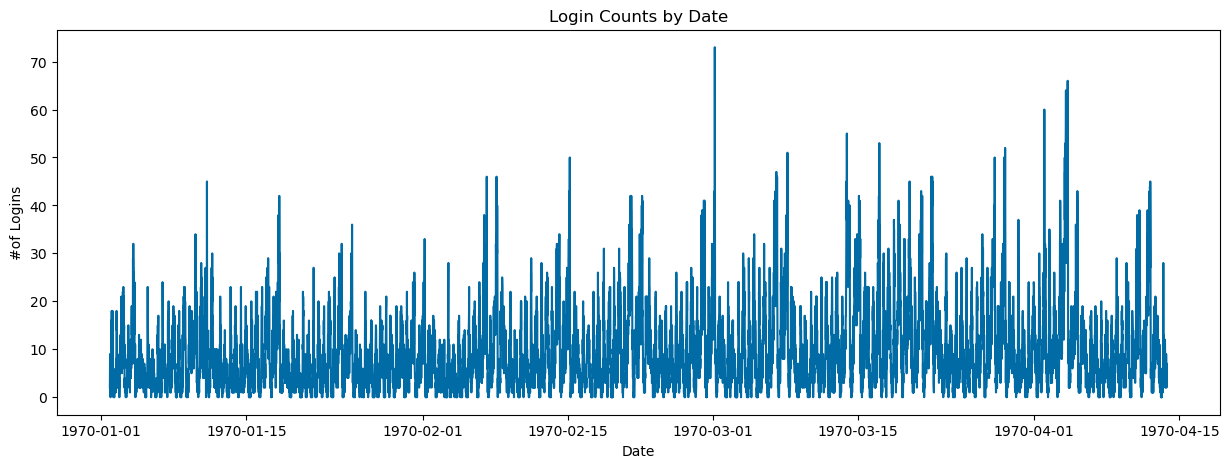

In [71]:
#initial data visualization
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Date')
plt.ylabel('#of Logins')
plt.title('Login Counts by Date')
plt.plot(delta.index, delta.login_count);

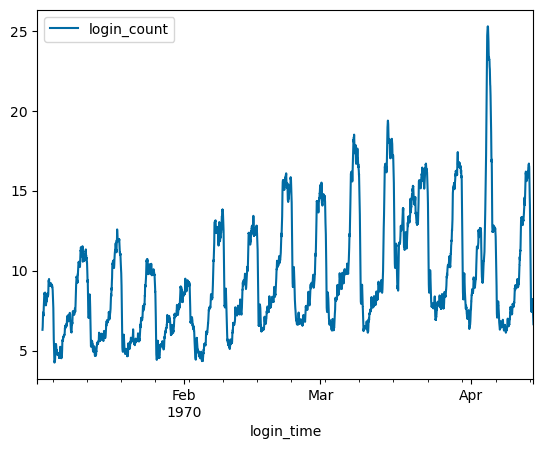

In [72]:
#Rolling chart used to better view the congested data.
delta.rolling(window=100).mean().plot()
plt.show()

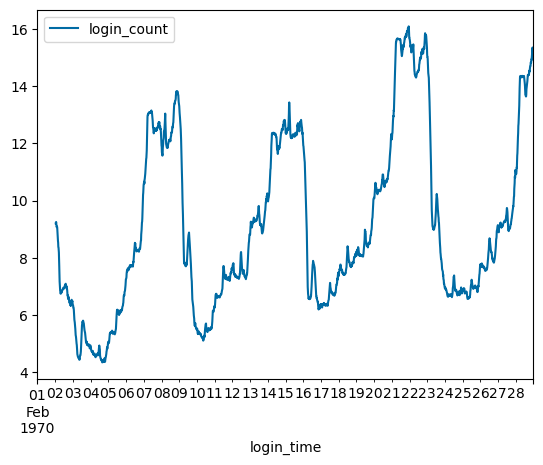

In [73]:
#Plot of only februrary
delta.loc['1970-02'].rolling(window=100).mean().plot()
plt.show()

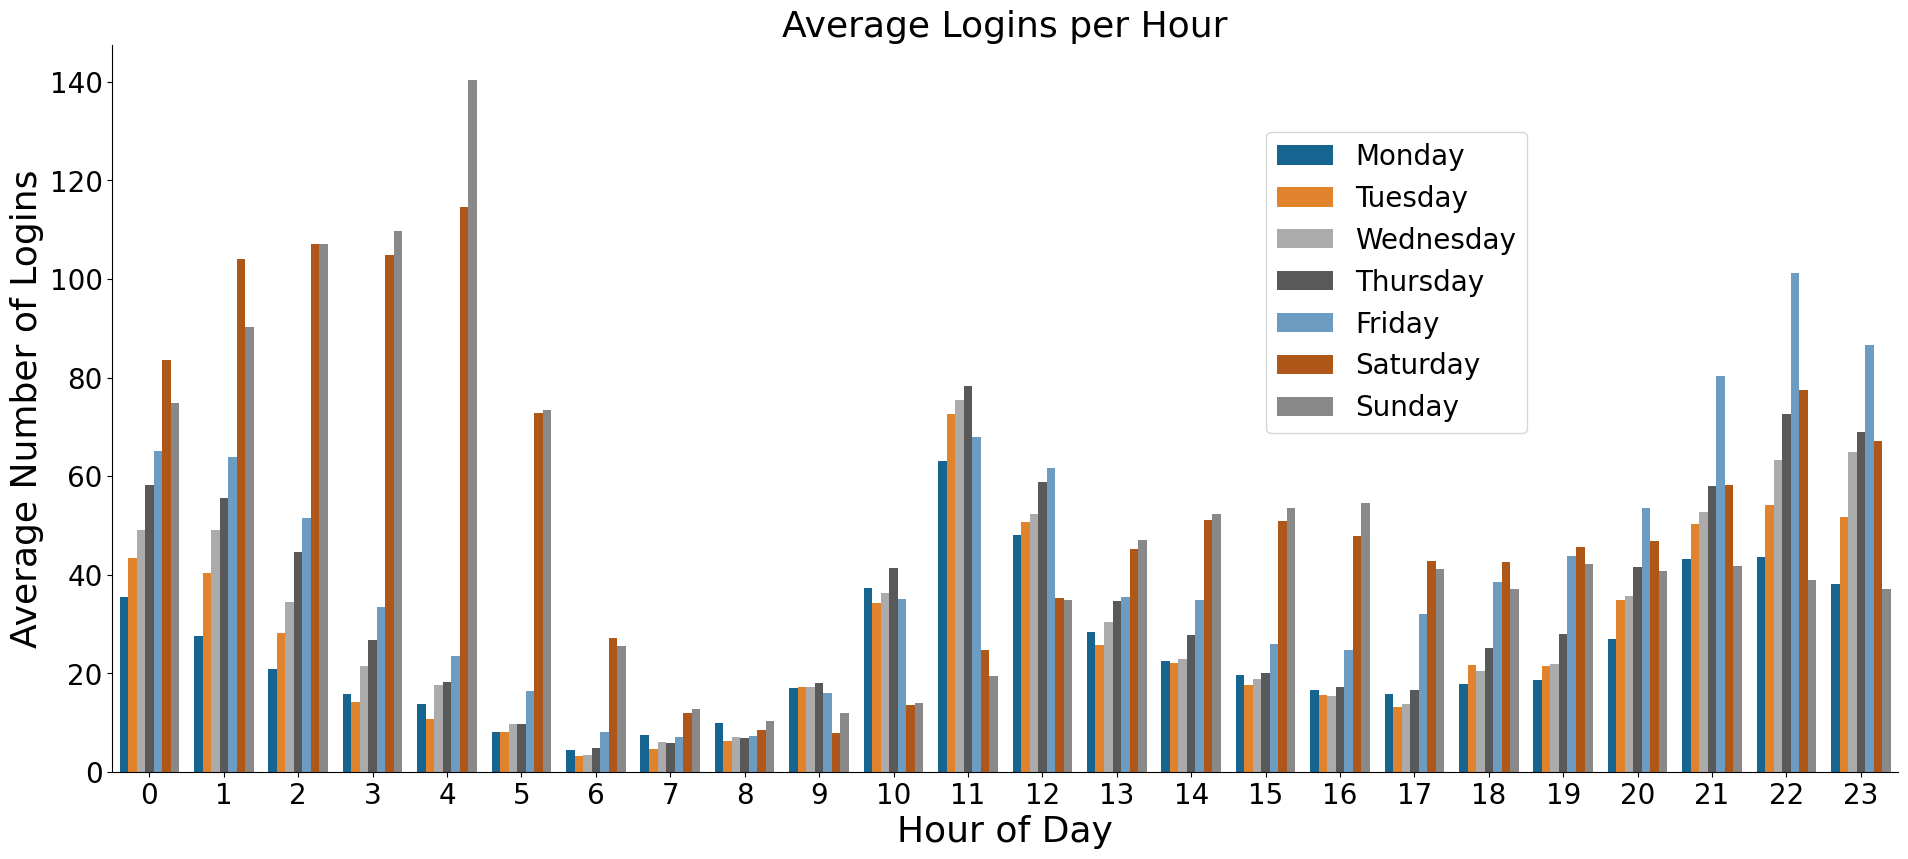

In [74]:
# resample index hourly
daily_logins = delta.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour',
                                   columns = 'day_of_week', aggfunc=np.mean).rename(
    columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])


avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()


sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)

ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour of Day', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20);

Login peak hours is from 22:00 to 5:00
Max peak hours between 3:00 to 5:00.
Logins followed a time-of-day cycle that loosly follow the inverse of standard working hours, where hours right
before/after the 9-5 see an increase, and then there's a 2-week cycle of peaks where it's obvious that 
employees are treating their bosses to an artisian old fashioned and ride home after pay day!

## Part 2 ‐ Experiment and metrics design

The scenario: 

   <i>The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.</i>

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

    To measure success, I would analyze the quantitative data surrounding toll bridge crossings before and after the change is implemented. The biggest key factor would be the number of toll reimbursement requests filed, as this would be a direct representation of program usage. 


2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    
   A.) I'd run a control group with a sample population of drivers for several weeks before the main roll out of the event in order to establish a baseline of usage to compare to. Its possible that not many drivers would utilize the program if toll reimbursement requests were too much of a hassle, or if tolls were too inexpensive to make the reimbursement process worthwhile. Once the baseline was established, I would continue with the main roll out and allow for several months of data collection to occur. Once the data was in hand, I'd compare it to the baseline as well as other data such as overall car crossings on the bridge, the numbers of tolls paid, and the time of day at which any spikes in traffic occured. 
    
   B.) To further analyze the data, I would perform a T-test  to determine whether toll reimbursement had a significant impact on the number of bridge crossings, and consequently the number of participant drivers. I would then look at the p-value to establish the likelihood that these numbers were simply a probablistic outcome. 
    
   C.) Once the data is analyzed, I'd interpret the program as a success if we saw a significant spike in crossings and a large number toll reimbursement requests. For the purposed of this test, I'd consider anything over 5% increase a success. In which case, I would present the data to the City, with the recommendation that only program promotion increases. 
    
    If the test results showed too few requests or crossings, I'd recommend to the city that the reimbursement process is eased to encourage drivers to participate, or introduce other incentives. I would not recommend that the city increase tolls overall though, as this could decrease all traffic, not just increase toll reimbursement requests. As a secondary incentive, it could be beneficial to pursue other driver benefits, such as lower fare taxes or other means of increasing individual driver earnings per trip. 

## Part 3 ‐ Predictive modeling

In [75]:
# reading in data and observing first few rows
df = pd.read_json("/Users/evanmeeks/Documents/data_education/Springboard/Github Projects/ultimate_challenge/ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [76]:
#checking data types
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [77]:
#converting date columns from Objects to Datetime
df['signup_date'] = pd.to_datetime(df["signup_date"])
df['last_trip_date'] = pd.to_datetime(df["last_trip_date"])

In [78]:
#Determining the number of null values
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [79]:
#filling phone null values with 'Other' an then encoding phone and city for analysis. 
df['phone'].fillna('Other', inplace=True)
df = pd.get_dummies(df, columns = ['city', 'phone'])

In [80]:
#Determining the average ratings and using to fill in null values. 
display(df['avg_rating_of_driver'].mean())
display(df['avg_rating_by_driver'].mean())
df['avg_rating_of_driver'].fillna(4.6, inplace=True)
df['avg_rating_by_driver'].fillna(4.78, inplace=True)

4.601559291274655

4.77815819594771

In [81]:
#Rechecking null values.
df.isnull().sum()

trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
city_Astapor              0
city_King's Landing       0
city_Winterfell           0
phone_Android             0
phone_Other               0
phone_iPhone              0
dtype: int64

In [82]:
#Verifying data types, null value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    50000 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   ultimate_black_user     50000 non-null  bool          
 7   weekday_pct             50000 non-null  float64       
 8   avg_dist                50000 non-null  float64       
 9   avg_rating_by_driver    50000 non-null  float64       
 10  city_Astapor            50000 non-null  uint8         
 11  city_King's Landing     50000 non-null  uint8         
 12  city_Winterfell         50000 non-null  uint8 

In [83]:
#Determining the date that the data was pulled, creating a variable to hold the 30 days preceding it
# Creating an 'Active Status' column as a boolean value if they were active in the last 30 days. 
pull_date = df.last_trip_date.max()
cut_off_day = pull_date - pd.Timedelta('30 days')
df['active_status'] = (df.last_trip_date > cut_off_day).astype('int')


In [84]:
#The data was pulled at midnight on July 1st. Since this model only cares about the last 30 days, everything
# prior to June can be ignored, and a retention rate can be calculated. 
fraction_retained = df['active_status'].mean()
print("{}% of June's users were retained.".format(round(fraction_retained,3)*100))

36.6% of June's users were retained.


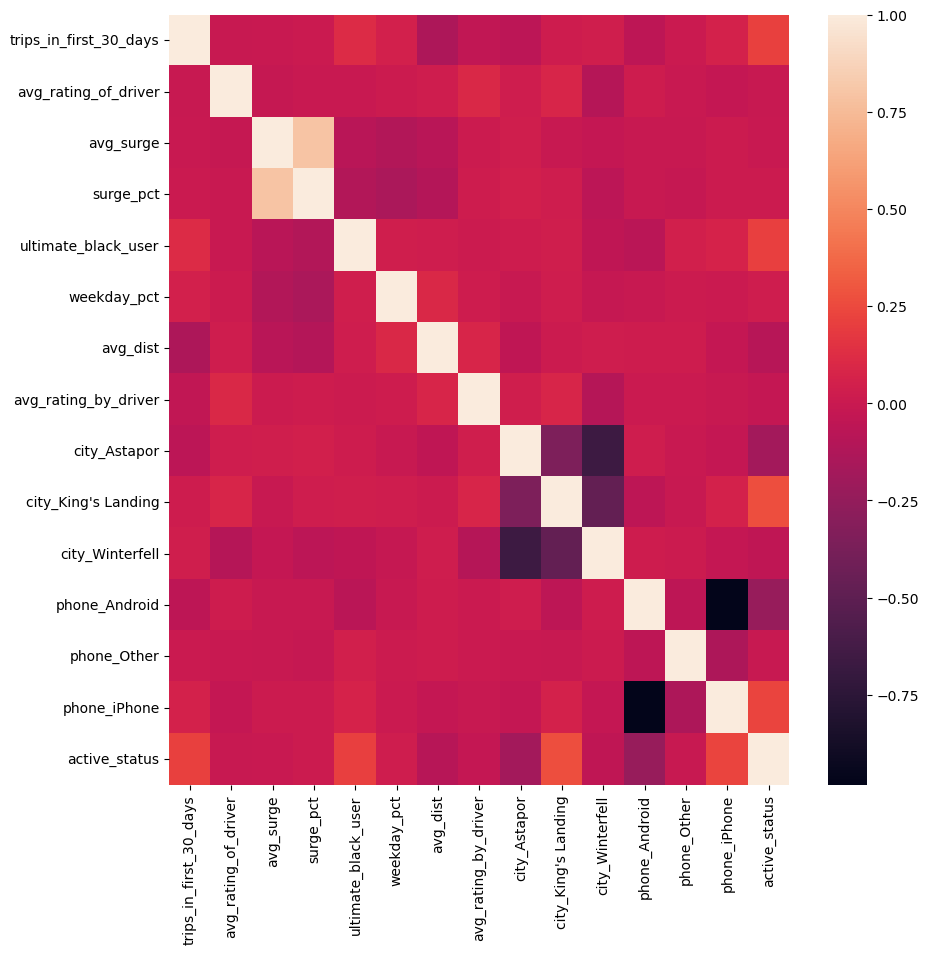

In [85]:
#Based off of the below, having an iPhone, a trip within 30 days of sign up, and being an ultimate Black user 
# appear to have the highest correlation to active status. Those taking trips in King's Landing were also more
# likely to stay active. Android users and those in Astapor were more likely to be inactive. 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr())
plt.show()

## Part 3 ‐ Predictive modeling

In [114]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

active_user = df[df.active_status == 1]
inactive_user = df[df.active_status == 0]

feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [123]:
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})


In [124]:
# define features and target
X = df[feature_columns]
y = df.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=123)

In [125]:
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [126]:
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 42, n_estimators=10, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

[18:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:15:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:15:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:15:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:15:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:15:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:16:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:16:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

[18:16:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:16:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414656755/work/src/learner.cc:767

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012...
                                     max_delta_step=0, max_depth=8,
                                     max_leaves=0, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=10, n_jobs=0,
    

In [127]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 0, 'scale_pos_weight': 0.95, 'subsample': 1}
0.7843


In [128]:
optimized_parameters = {'objective' : 'binary:logistic', 
                        'random_state' : 42, 
                        'n_estimators':10, 
                        'max_depth': 8,
                        'gamma': 3, 
                        'learning_rate': 0.25, 
                        'max_delta_step': 0, 
                        'min_child_weight': 1, 
                        'scale_pos_weight': 0.95, 
                        'subsample': 0.8}



In [140]:
xgb_opt = XGBClassifier(**optimized_parameters)
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [147]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("Accuracy Score: {}.".format(round(score,3)))


Accuracy Score: 0.805.


In [149]:
# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic', random_state = 42, n_estimators=200, max_depth= 8)
# train final model
xg_clf_final.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

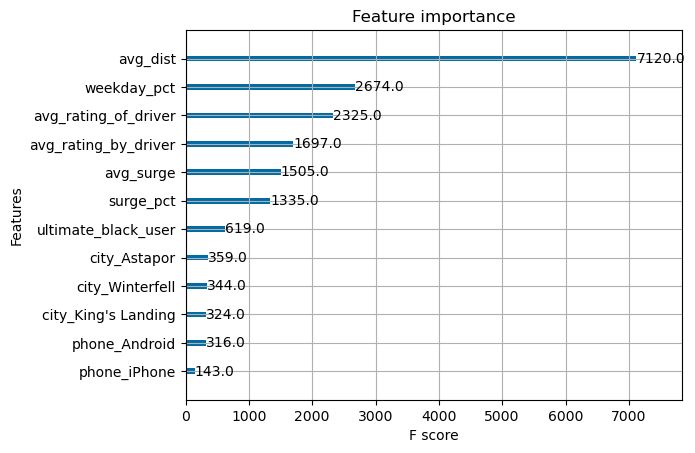

In [150]:
plot_importance(xg_clf_final);

## Conclusion

After importing the data, basic cleaning was done. Numerical missing values were filled with their respective averages, and "other" used as a fill for missing variables in the phone column. The phone column was then converted into dummy variables to more easily observe trends between phone types.  Variables of the pull date and the date 30 days prior for trend analysis, and then a column of boolean values created for determining whether a user was active or not for that month.  From that, it was determined that 36.6% of June's users were retained. Then a correlation heatmap was created to visualize the correlation between different variables and used to steer further analysis. 

After evaluating the heatmap, a model was created. To begin with, the active user column was split into two columns, and then a list of desired features built. A dictionary constructed of statistical attributes of the active user columns was created. The data was then split into training sets. An XGB Classifier was chosen as the alogirithm for this model for it's reputation of being easily deployed while highly accurate. A grid search was then ran to determine the best values for each parameter in order to maximize the accuracy of the model, before those values were put into a dictionary and used to train the production model. 


The average distance, weekday percentage and average driver rating were the top three indidcators of rider retention. To improve retention, Ultimate may consider rewards programs for both those who ride frequently, and those who are consistently rated higher by drivers (Better experience for both rider and driver means higher retention). Furthermore, Ultimate may explore options to increase rider experience in Astaphor, incentivise riders to join Ultimate Black, and more heavily investigate the negative correlation between Android users and retention rates. This could indicate an issue with riders' experiences within the Android app, or could be a trend more tied to the personalities of the riders themselves. 